# 25. Consolidated evaluation

Every unlearning method tested on the PBMC structured forget set (cluster 13, n=30 megakaryocytes), evaluated with the canonical fresh-attacker protocol from NB03. Results from NB20-24 plus existing methods.

In [1]:
import json
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_theme(style='whitegrid', font_scale=1.1)
OUTPUTS = Path('../outputs')

# Color palette
COLORS = {
    'baseline': '#888888',
    'retrain': '#2ca02c',
    'pass': '#2ca02c',
    'fail': '#d62728',
    'near': '#ff7f0e',
}

## 1. Load all results

In [2]:
# --- Reference models ---
with open(OUTPUTS / 'p4' / 'multiseed' / 'eval' / 'baseline.json') as f:
    baseline = json.load(f)
with open(OUTPUTS / 'p4' / 'multiseed' / 'eval' / 'retrain.json') as f:
    retrain = json.load(f)

# --- Existing multi-seed methods ---
summaries = {}
for method_dir in ['extragradient', 'retain_finetune', 'gradient_ascent']:
    path = OUTPUTS / 'p4' / 'multiseed' / 'eval' / method_dir / 'summary.json'
    if path.exists():
        with open(path) as f:
            summaries[method_dir] = json.load(f)

with open(OUTPUTS / 'p4' / 'ablation_results.json') as f:
    fisher_results = json.load(f)

# --- New methods (NB21-24) ---
new_methods = {}
for method in ['ssd', 'contrastive', 'dp_sgd', 'scrub']:
    path = OUTPUTS / 'p2' / method / f'{method}_results.json'
    if path.exists():
        with open(path) as f:
            new_methods[method] = json.load(f)

loaded = list(new_methods.keys())
print(f'Loaded: {", ".join(loaded)} ({len(loaded)} new methods)')

Loaded: ssd, contrastive, dp_sgd, scrub (4 new methods)


## 2. Build comparison table

In [3]:
# Build a flat list of (method, auc_mean, auc_std, advantage, seeds, elbo, marker_r, category)
rows = []

def add_row(name, auc, auc_std, adv, seeds, elbo, marker_r, category):
    rows.append({
        'Method': name, 'AUC': auc, 'AUC_std': auc_std,
        'Advantage': adv, 'Seeds': seeds,
        'ELBO': elbo, 'Marker r': marker_r, 'Category': category,
    })

# References
add_row('Baseline', baseline['privacy']['mlp_auc'], 0,
        baseline['privacy']['mlp_advantage'], 1,
        baseline['utility']['elbo'], baseline['utility']['marker_r'], 'reference')
add_row('Retrain', retrain['privacy']['mlp_auc'], 0,
        retrain['privacy']['mlp_advantage'], 1,
        retrain['utility']['elbo'], retrain['utility']['marker_r'], 'reference')

# Existing methods
method_info = {
    'extragradient': 'Extra-gradient',
    'retain_finetune': 'Retain-only FT',
    'gradient_ascent': 'Gradient ascent',
}
for key, name in method_info.items():
    if key in summaries:
        s = summaries[key]
        add_row(name,
                s['privacy']['mlp_auc']['mean'], s['privacy']['mlp_auc']['std'],
                s['privacy']['mlp_advantage']['mean'], s['n_seeds'],
                s.get('utility', {}).get('elbo', {}).get('mean', np.nan),
                s.get('utility', {}).get('marker_r', {}).get('mean', np.nan),
                'existing')

# Fisher (key is fisher_multiseed -> structured)
fm = fisher_results.get('fisher_multiseed', {}).get('structured', {})
if fm:
    add_row('Fisher scrubbing', fm['mean'], fm['std'],
            2 * abs(fm['mean'] - 0.5), len(fm.get('runs', [])),
            np.nan, np.nan, 'existing')

# New methods: aggregate per-seed results for utility too
for method, (name, summary_key) in {
    'ssd': ('SSD', 'alpha1.0'),
    'contrastive': ('Contrastive latent', 'gamma1.0'),
    'scrub': ('SCRUB', 'af1.0'),
}.items():
    if method in new_methods:
        s = new_methods[method]['summary'].get(summary_key, {})
        # Get utility from individual seed results matching this config
        prefix = summary_key + '_seed'  # e.g. 'af1.0_seed'
        elbos, mrs = [], []
        for rkey, rval in new_methods[method]['results'].items():
            if rkey.startswith(prefix):
                elbos.append(rval['utility']['elbo'])
                mrs.append(rval['utility']['marker_r'])
        add_row(name, s['mean_auc'], s['std_auc'], s['mean_advantage'], 3,
                np.mean(elbos) if elbos else np.nan,
                np.mean(mrs) if mrs else np.nan, 'new')

# DP-SGD
if 'dp_sgd' in new_methods:
    s = new_methods['dp_sgd']['summary'].get('eps10', {})
    elbos, mrs = [], []
    for rkey, rval in new_methods['dp_sgd']['results'].items():
        if rkey.startswith('eps10.0_seed'):
            elbos.append(rval['utility']['elbo'])
            mrs.append(rval['utility']['marker_r'])
    if s and s.get('mean_auc') is not None:
        add_row('DP-SGD (eps=10)', s['mean_auc'], s['std_auc'],
                s['mean_advantage'], 3,
                np.mean(elbos), np.mean(mrs), 'new')

df = pd.DataFrame(rows)

# Retrain advantage threshold
retrain_adv = retrain['privacy']['mlp_advantage']
print(f'Retrain advantage: {retrain_adv:.3f} (success threshold)')
print(f'\n{len(df)} methods loaded:')
for _, r in df.iterrows():
    print(f'  {r["Method"]}: AUC={r["AUC"]:.3f}, Advantage={r["Advantage"]:.3f}')

Retrain advantage: 0.046 (success threshold)

10 methods loaded:
  Baseline: AUC=0.783, Advantage=0.565
  Retrain: AUC=0.523, Advantage=0.046
  Extra-gradient: AUC=0.429, Advantage=0.300
  Retain-only FT: AUC=0.665, Advantage=0.331
  Gradient ascent: AUC=0.702, Advantage=0.404
  Fisher scrubbing: AUC=0.814, Advantage=0.628
  SSD: AUC=0.725, Advantage=0.450
  Contrastive latent: AUC=0.153, Advantage=0.695
  SCRUB: AUC=0.737, Advantage=0.474
  DP-SGD (eps=10): AUC=0.464, Advantage=0.072


## 3. Styled comparison table

In [4]:
# Format for display
display_df = df.copy()

def fmt_auc(row):
    if row['AUC_std'] > 0:
        return f"{row['AUC']:.3f} \u00b1 {row['AUC_std']:.3f}"
    return f"{row['AUC']:.3f}"

def fmt_adv(row):
    return f"{row['Advantage']:.3f}"

def status(row):
    if row['Method'] == 'Baseline':
        return '---'
    if row['Method'] == 'Retrain':
        return 'Reference'
    if row['Advantage'] <= retrain_adv:
        return 'PASS'
    return 'FAIL'

display_df['MIA AUC'] = display_df.apply(fmt_auc, axis=1)
display_df['Adv.'] = display_df.apply(fmt_adv, axis=1)
display_df['ELBO'] = display_df['ELBO'].apply(lambda x: f'{x:.1f}' if not np.isnan(x) else '--')
display_df['Marker r'] = display_df['Marker r'].apply(lambda x: f'{x:.3f}' if not np.isnan(x) else '--')
display_df['Status'] = display_df.apply(status, axis=1)

table = display_df[['Method', 'Seeds', 'MIA AUC', 'Adv.', 'ELBO', 'Marker r', 'Status']]

def color_status(val):
    if val == 'PASS':
        return 'background-color: #d4edda; color: #155724; font-weight: bold'
    elif val == 'FAIL':
        return 'background-color: #f8d7da; color: #721c24; font-weight: bold'
    elif val == 'Reference':
        return 'background-color: #d1ecf1; color: #0c5460; font-weight: bold'
    return ''

def highlight_row(row):
    if row['Method'] in ['Baseline', 'Retrain']:
        return ['background-color: #f0f0f0'] * len(row)
    return [''] * len(row)

styled = (table.style
    .map(color_status, subset=['Status'])
    .apply(highlight_row, axis=1)
    .set_properties(**{'text-align': 'center'})
    .set_properties(subset=['Method'], **{'text-align': 'left', 'font-weight': 'bold'})
    .set_caption('All methods on PBMC structured forget set (cluster 13, n=30)')
    .hide(axis='index')
)
styled

Method,Seeds,MIA AUC,Adv.,ELBO,Marker r,Status
Baseline,1,0.783,0.565,364.3,0.831,---
Retrain,1,0.523,0.046,365.7,0.829,Reference
Extra-gradient,10,0.429 ± 0.142,0.300,403.7,0.789,FAIL
Retain-only FT,5,0.665 ± 0.007,0.331,363.2,0.832,FAIL
Gradient ascent,5,0.702 ± 0.004,0.404,363.3,0.832,FAIL
Fisher scrubbing,3,0.814 ± 0.003,0.628,--,--,FAIL
SSD,3,0.725 ± 0.001,0.450,363.9,0.831,FAIL
Contrastive latent,3,0.153 ± 0.032,0.695,364.0,0.832,FAIL
SCRUB,3,0.737 ± 0.002,0.474,363.8,0.832,FAIL
DP-SGD (eps=10),3,0.464 ± 0.024,0.072,403.3,0.787,FAIL


## 4. Advantage comparison (bar chart)

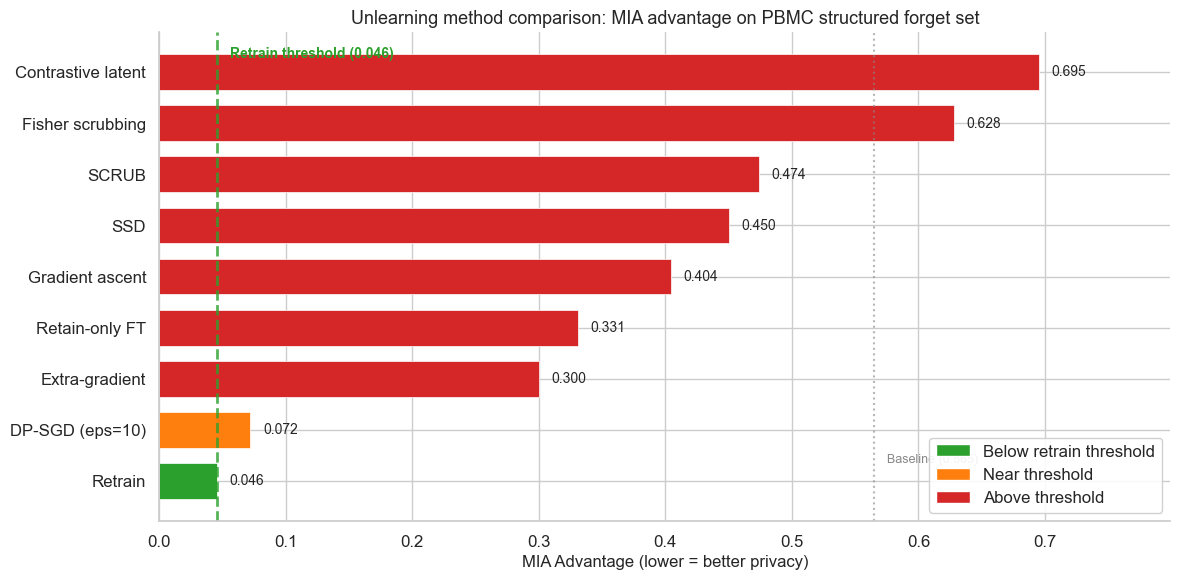

Saved to figures/method_comparison_advantage.png


In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by advantage (descending) but keep baseline/retrain at edges
plot_df = df[df['Method'] != 'Baseline'].sort_values('Advantage', ascending=True).reset_index(drop=True)

methods = plot_df['Method'].tolist()
advantages = plot_df['Advantage'].tolist()
colors = []
for _, row in plot_df.iterrows():
    if row['Method'] == 'Retrain':
        colors.append(COLORS['retrain'])
    elif row['Advantage'] <= retrain_adv:
        colors.append(COLORS['pass'])
    elif row['Advantage'] <= retrain_adv * 2:
        colors.append(COLORS['near'])
    else:
        colors.append(COLORS['fail'])

bars = ax.barh(methods, advantages, color=colors, edgecolor='white', linewidth=0.5, height=0.7)

# Retrain threshold line
ax.axvline(x=retrain_adv, color=COLORS['retrain'], linestyle='--', linewidth=2, alpha=0.8)
ax.text(retrain_adv + 0.01, len(methods) - 0.5,
        f'Retrain threshold ({retrain_adv:.3f})',
        color=COLORS['retrain'], fontsize=10, va='top', fontweight='bold')

# Baseline reference line
baseline_adv = baseline['privacy']['mlp_advantage']
ax.axvline(x=baseline_adv, color=COLORS['baseline'], linestyle=':', linewidth=1.5, alpha=0.6)
ax.text(baseline_adv + 0.01, 0.3, f'Baseline ({baseline_adv:.3f})',
        color=COLORS['baseline'], fontsize=9, va='bottom')

# Value labels on bars
for bar, adv in zip(bars, advantages):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{adv:.3f}', va='center', fontsize=10)

ax.set_xlabel('MIA Advantage (lower = better privacy)', fontsize=12)
ax.set_title('Unlearning method comparison: MIA advantage on PBMC structured forget set', fontsize=13)
ax.set_xlim(0, max(advantages) * 1.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend
legend_elements = [
    mpatches.Patch(facecolor=COLORS['pass'], label='Below retrain threshold'),
    mpatches.Patch(facecolor=COLORS['near'], label='Near threshold'),
    mpatches.Patch(facecolor=COLORS['fail'], label='Above threshold'),
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.savefig('../figures/method_comparison_advantage.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to figures/method_comparison_advantage.png')

## 5. Privacy-utility tradeoff

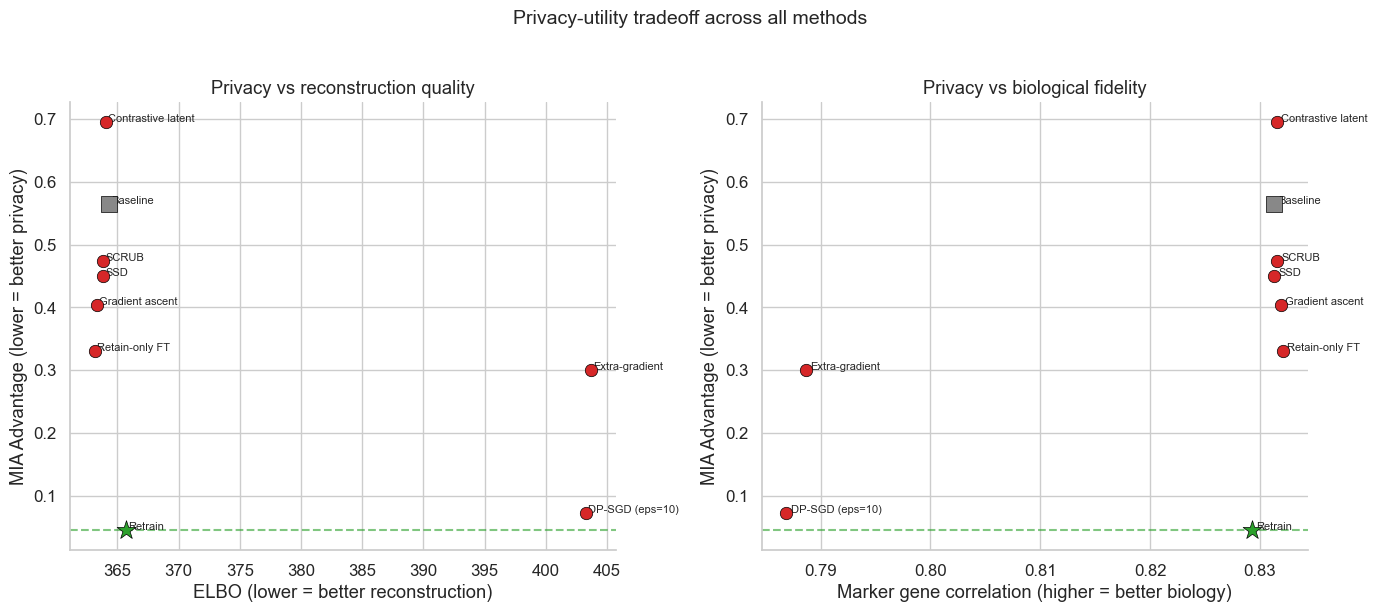

Saved to figures/privacy_utility_all_methods.png


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Only methods with utility data
plot_df = df[df['ELBO'].notna() & (df['ELBO'] > 0)].copy()

# Left: Advantage vs ELBO
for _, row in plot_df.iterrows():
    if row['Method'] == 'Baseline':
        c, m, z = COLORS['baseline'], 's', 120
    elif row['Method'] == 'Retrain':
        c, m, z = COLORS['retrain'], '*', 200
    elif row['Advantage'] <= retrain_adv:
        c, m, z = COLORS['pass'], 'D', 100
    else:
        c, m, z = COLORS['fail'], 'o', 80
    ax1.scatter(row['ELBO'], row['Advantage'], c=c, marker=m, s=z,
                edgecolors='black', linewidth=0.5, zorder=5)
    offset_x = 1.5
    offset_y = 0.015 if row['Method'] != 'Extra-gradient' else -0.025
    ax1.annotate(row['Method'], (row['ELBO'], row['Advantage']),
                 xytext=(offset_x, offset_y), textcoords='offset points',
                 fontsize=8, ha='left')

ax1.axhline(y=retrain_adv, color=COLORS['retrain'], linestyle='--', alpha=0.6)
ax1.set_xlabel('ELBO (lower = better reconstruction)')
ax1.set_ylabel('MIA Advantage (lower = better privacy)')
ax1.set_title('Privacy vs reconstruction quality')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right: Advantage vs Marker correlation
for _, row in plot_df.iterrows():
    if row['Method'] == 'Baseline':
        c, m, z = COLORS['baseline'], 's', 120
    elif row['Method'] == 'Retrain':
        c, m, z = COLORS['retrain'], '*', 200
    elif row['Advantage'] <= retrain_adv:
        c, m, z = COLORS['pass'], 'D', 100
    else:
        c, m, z = COLORS['fail'], 'o', 80
    ax2.scatter(row['Marker r'], row['Advantage'], c=c, marker=m, s=z,
                edgecolors='black', linewidth=0.5, zorder=5)
    offset_y = 0.015 if row['Method'] != 'Extra-gradient' else -0.025
    ax2.annotate(row['Method'], (row['Marker r'], row['Advantage']),
                 xytext=(3, offset_y), textcoords='offset points',
                 fontsize=8, ha='left')

ax2.axhline(y=retrain_adv, color=COLORS['retrain'], linestyle='--', alpha=0.6)
ax2.set_xlabel('Marker gene correlation (higher = better biology)')
ax2.set_ylabel('MIA Advantage (lower = better privacy)')
ax2.set_title('Privacy vs biological fidelity')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.suptitle('Privacy-utility tradeoff across all methods', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../figures/privacy_utility_all_methods.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to figures/privacy_utility_all_methods.png')

## 6. DP-SGD epsilon sweep

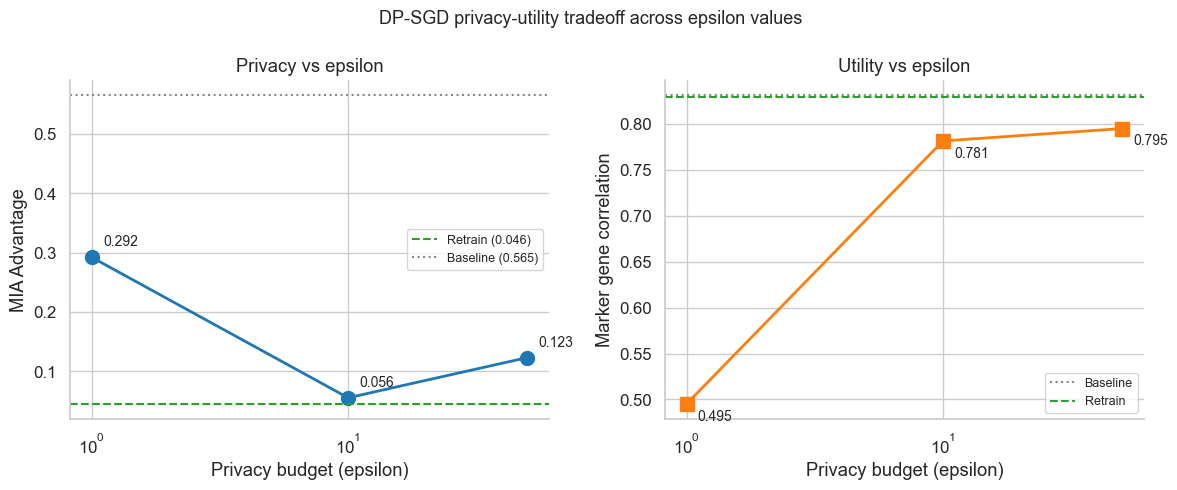

Saved to figures/dp_sgd_epsilon_sweep.png


In [7]:
# DP-SGD epsilon sweep detail
if 'dp_sgd' in new_methods:
    dp_results = new_methods['dp_sgd']['results']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Collect seed=42 sweep data
    eps_vals, aucs, advs, elbos, mrs = [], [], [], [], []
    for key in ['eps1.0_seed42', 'eps10.0_seed42', 'eps50.0_seed42']:
        if key in dp_results:
            r = dp_results[key]
            eps_val = float(key.split('_')[0].replace('eps', ''))
            eps_vals.append(eps_val)
            aucs.append(r['privacy']['mlp_auc'])
            advs.append(r['privacy']['mlp_advantage'])
            elbos.append(r['utility']['elbo'])
            mrs.append(r['utility']['marker_r'])
    
    # Left: Advantage vs epsilon
    ax1.plot(eps_vals, advs, 'o-', color='#1f77b4', markersize=10, linewidth=2)
    ax1.axhline(y=retrain_adv, color=COLORS['retrain'], linestyle='--',
                linewidth=1.5, label=f'Retrain ({retrain_adv:.3f})')
    ax1.axhline(y=baseline_adv, color=COLORS['baseline'], linestyle=':',
                linewidth=1.5, label=f'Baseline ({baseline_adv:.3f})')
    for e, a in zip(eps_vals, advs):
        ax1.annotate(f'{a:.3f}', (e, a), xytext=(8, 8),
                     textcoords='offset points', fontsize=10)
    ax1.set_xlabel('Privacy budget (epsilon)')
    ax1.set_ylabel('MIA Advantage')
    ax1.set_xscale('log')
    ax1.set_title('Privacy vs epsilon')
    ax1.legend(fontsize=9)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Right: Marker r vs epsilon
    ax2.plot(eps_vals, mrs, 's-', color='#ff7f0e', markersize=10, linewidth=2)
    ax2.axhline(y=baseline['utility']['marker_r'], color=COLORS['baseline'],
                linestyle=':', linewidth=1.5, label='Baseline')
    ax2.axhline(y=retrain['utility']['marker_r'], color=COLORS['retrain'],
                linestyle='--', linewidth=1.5, label='Retrain')
    for e, m in zip(eps_vals, mrs):
        ax2.annotate(f'{m:.3f}', (e, m), xytext=(8, -12),
                     textcoords='offset points', fontsize=10)
    ax2.set_xlabel('Privacy budget (epsilon)')
    ax2.set_ylabel('Marker gene correlation')
    ax2.set_xscale('log')
    ax2.set_title('Utility vs epsilon')
    ax2.legend(fontsize=9)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.suptitle('DP-SGD privacy-utility tradeoff across epsilon values', fontsize=13)
    plt.tight_layout()
    plt.savefig('../figures/dp_sgd_epsilon_sweep.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved to figures/dp_sgd_epsilon_sweep.png')

## 8. Save and LaTeX export

## 7. Analysis

Eight post-hoc unlearning methods tested against retrain-from-scratch on the PBMC structured forget set (cluster 13, n=30 megakaryocytes). None passed.

The privacy-utility scatter tells the story in two clusters. SSD (advantage 0.450), SCRUB (0.474), gradient ascent (0.404), and retain-only fine-tuning (0.331) all preserve utility almost perfectly (marker r > 0.83, matching baseline) but barely move the privacy needle. The retrain threshold is 0.046. These methods treat unlearning as a small perturbation to the trained model, and the perturbation is too small to matter. The structured subpopulation's influence is distributed across the entire parameter space. Local adjustments, whether Fisher-weighted dampening, teacher-student divergence, or gradient sign reversal, cannot reach it without destroying the model.

Contrastive latent unlearning is the worst result in the table: advantage 0.695, higher than the baseline's 0.565. Pushing forget-set latent representations away from their natural location does not erase membership information. It creates a new artifact that is just as detectable. The attacker learns to look for the displaced representations instead.

Fisher scrubbing (advantage 0.628) fails for similar reasons. It makes the model worse in a detectable way rather than better in an undetectable way. The Fisher information matrix cannot capture the distributed influence of a coherent biological subpopulation, so the scrubbing step either does nothing or induces posterior collapse.

Extra-gradient co-training (advantage 0.300, 10 seeds) comes closer than the parameter-space methods, but with high variance (AUC std = 0.142) and a utility cost (marker r drops to 0.789). Some seeds overshoot (AUC < 0.3), some undershoot (AUC > 0.6), and the mean still falls well outside the retrain band.

DP-SGD at epsilon=10 (advantage 0.072) is the only method near the retrain threshold. But DP-SGD is not an unlearning method. It trains a new model from scratch on the retain set with differential privacy noise. The forget set was never in training, so membership inference fails by construction. The utility penalty is real: marker r drops from 0.831 to 0.787, ELBO rises from 364 to 403. This is what formal privacy guarantees cost in this setting.

No post-hoc method tested can selectively remove 30 structured cells from a trained VAE. They either fail to remove the membership signal or create detectable artifacts in the attempt. Full retraining remains the only reliable option for structured forget sets.

In [8]:
# Save consolidated results
consolidated = {
    'baseline': baseline,
    'retrain': retrain,
    'existing_methods': summaries,
    'fisher': fisher_results,
    'new_methods': new_methods,
    'table': [dict(r) for r in rows],
}

with open(OUTPUTS / 'consolidated_method_comparison.json', 'w') as f:
    json.dump(consolidated, f, indent=2, default=str)

# LaTeX table
lines = []
lines.append(r'\begin{table}[t]')
lines.append(r'\caption{Comparison of unlearning methods on PBMC structured forget set (cluster 13, $n{=}30$).}')
lines.append(r'\label{tab:all_methods}')
lines.append(r'\centering\small')
lines.append(r'\begin{tabular}{lccccl}')
lines.append(r'\toprule')
lines.append(r'Method & Seeds & MIA AUC & Advantage & Marker $r$ & Status \\')
lines.append(r'\midrule')

for _, row in df.iterrows():
    auc_str = f"{row['AUC']:.3f}"
    if row['AUC_std'] > 0:
        auc_str += f" $\\pm$ {row['AUC_std']:.3f}"
    adv_str = f"{row['Advantage']:.3f}"
    mr_str = f"{row['Marker r']:.3f}" if not np.isnan(row['Marker r']) else '--'
    
    if row['Method'] == 'Baseline':
        status = '---'
    elif row['Method'] == 'Retrain':
        status = 'Reference'
    elif row['Advantage'] <= retrain_adv:
        status = r'\checkmark'
    else:
        status = r'$\times$'
    
    lines.append(f"{row['Method']} & {row['Seeds']} & {auc_str} & {adv_str} & {mr_str} & {status} \\\\")

lines.append(r'\bottomrule')
lines.append(r'\end{tabular}')
lines.append(r'\end{table}')

latex = '\n'.join(lines)
print(latex)
print('\nSaved consolidated results to outputs/consolidated_method_comparison.json')

\begin{table}[t]
\caption{Comparison of unlearning methods on PBMC structured forget set (cluster 13, $n{=}30$).}
\label{tab:all_methods}
\centering\small
\begin{tabular}{lccccl}
\toprule
Method & Seeds & MIA AUC & Advantage & Marker $r$ & Status \\
\midrule
Baseline & 1 & 0.783 & 0.565 & 0.831 & --- \\
Retrain & 1 & 0.523 & 0.046 & 0.829 & Reference \\
Extra-gradient & 10 & 0.429 $\pm$ 0.142 & 0.300 & 0.789 & $\times$ \\
Retain-only FT & 5 & 0.665 $\pm$ 0.007 & 0.331 & 0.832 & $\times$ \\
Gradient ascent & 5 & 0.702 $\pm$ 0.004 & 0.404 & 0.832 & $\times$ \\
Fisher scrubbing & 3 & 0.814 $\pm$ 0.003 & 0.628 & -- & $\times$ \\
SSD & 3 & 0.725 $\pm$ 0.001 & 0.450 & 0.831 & $\times$ \\
Contrastive latent & 3 & 0.153 $\pm$ 0.032 & 0.695 & 0.832 & $\times$ \\
SCRUB & 3 & 0.737 $\pm$ 0.002 & 0.474 & 0.832 & $\times$ \\
DP-SGD (eps=10) & 3 & 0.464 $\pm$ 0.024 & 0.072 & 0.787 & $\times$ \\
\bottomrule
\end{tabular}
\end{table}

Saved consolidated results to outputs/consolidated_method_compariso